In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from matplotlib import colors
from sklearn.metrics import mean_squared_error

%matplotlib inline

# Data processing

### Read data

In [2]:
dta_fname = "../Data/Does_Price_Matter_AER_merged.dta"

raw_df = pd.read_stata(dta_fname)
colnames = raw_df.columns
print(colnames)

cols_to_keep = [
                'treatment', 'control',
                'ratio',
                # 'ratio2', 'ratio3',
                'size',
                # 'size25', 'size50', 'size100', 'sizeno',
                'ask',
                # 'ask1', 'ask2', 'ask3',
                # 'askd1', 'askd2', 'askd3',
                'amount', 'gave', 'amountchange',
                'red0'#, 'blue0'
               ]
df = raw_df[cols_to_keep]

df.head()

Index(['treatment', 'control', 'ratio', 'ratio2', 'ratio3', 'size', 'size25',
       'size50', 'size100', 'sizeno', 'ask', 'askd1', 'askd2', 'askd3', 'ask1',
       'ask2', 'ask3', 'amount', 'gave', 'amountchange', 'hpa', 'ltmedmra',
       'freq', 'years', 'year5', 'mrm2', 'dormant', 'female', 'couple',
       'state50one', 'nonlit', 'cases', 'statecnt', 'stateresponse',
       'stateresponset', 'stateresponsec', 'stateresponsetminc', 'perbush',
       'close25', 'red0', 'blue0', 'redcty', 'bluecty', 'pwhite', 'pblack',
       'page18_39', 'ave_hh_sz', 'median_hhincome', 'powner', 'psch_atlstba',
       'pop_propurban'],
      dtype='object')


,treatment,control,ratio,size,ask,amount,gave,amountchange,red0
0,0,1,Control,Control,Control,0.0,0,-45.0,0.0
1,0,1,Control,Control,Control,0.0,0,-25.0,0.0
2,1,0,1,"$100,000",1x,0.0,0,-50.0,0.0
3,1,0,1,Unstated,1x,0.0,0,-25.0,0.0
4,1,0,1,"$50,000",1x,0.0,0,-15.0,1.0


### Remove control

In [3]:
# avg_control = np.mean(df[df["control"] == 1]["amountchange"])
# df_treatment = df[df["treatment"] == 1]
# df_treatment.loc[:, "amountchange"] = df_treatment.loc[:, "amountchange"] - avg_control
df_treatment = deepcopy(df)
df_treatment = df_treatment.dropna()

### Process data

In [4]:
ratio_map = {"Control": 0, 1: 1, 2: 2, 3: 3}
size_map = {"Control": 0, "$25,000": 1, "$50,000": 2, "$100,000": 3, "Unstated": 4}
ask_map = {"Control": 0, "1x": 1, "1.25x": 2, "1.50x": 3}
redblue_map = {0: 1, 1:2, np.nan: 0}

df_treatment.loc[:, "ratio"] = df_treatment.loc[:, "ratio"].map(ratio_map)
df_treatment.loc[:, "size"] = df_treatment.loc[:, "size"].map(size_map)
df_treatment.loc[:, "ask"] = df_treatment.loc[:, "ask"].map(ask_map)
df_treatment.loc[:, "red0"] = df_treatment.loc[:, "red0"].map(redblue_map)
df_treatment = df_treatment.astype({
    "ratio": np.int64, "size": np.int64, "ask": np.int64, "red0": np.int64})

df_treatment = df_treatment.drop(["treatment", "control"], axis=1)

df_treatment.head()

,ratio,size,ask,amount,gave,amountchange,red0
0,0,0,0,0.0,0,-45.0,1
1,0,0,0,0.0,0,-25.0,1
2,1,3,1,0.0,0,-50.0,1
3,1,4,1,0.0,0,-25.0,1
4,1,2,1,0.0,0,-15.0,2


In [5]:
Z = df_treatment.to_numpy()
X = Z[:, [0, 1, 2, 6]] #- 1
y = Z[:, 3] / 100 # (np.max(y) - np.min(y))
y = y.reshape((-1, 1))

num_data = X.shape[0]

# Analysis

### Rashomon

In [6]:
from rashomon import tva
from rashomon import loss
from rashomon import counter
from rashomon import metrics
from rashomon import extract_pools
from rashomon.aggregate import RAggregate_profile, RAggregate
from rashomon.sets import RashomonSet, RashomonProblemCache, RashomonSubproblemCache


%load_ext autoreload
%autoreload 2

In [7]:
def print_pools(R_set, rashomon_profiles, idx, profiles, policies_mask, all_policies=None,
               policy_means=None):
    r_set = R_set[idx]
    
    pi_policies_profiles_r = {}
    for k, profile in enumerate(profiles):
        if rashomon_profiles[k].sigma[r_set[k]] is None and rashomon_profiles[k].Q[r_set[k]] == 0:
            pi_policies_r_k = {i: None for i in range(len(policies_mask[k]))}
            pass
        else:
            _, pi_policies_r_k = extract_pools.extract_pools(
                policies_profiles_masked[k],
                rashomon_profiles[k].sigma[r_set[k]]
            )
        pi_policies_profiles_r[k] = pi_policies_r_k
    
    pi_pools_r, pi_policies_r = extract_pools.aggregate_pools(pi_policies_profiles_r, policies_ids_profiles)
    if policy_means is not None:
        pool_means_r = loss.compute_pool_means(policy_means, pi_pools_r)
    else:
        pool_means_r = None
    
    for k, v in pi_pools_r.items():
        if all_policies is not None:
            print(k, ":", [all_policies[x] for x in v])
        else:
            print(k, ":", v)
        if pool_means_r is not None:
            print(pool_means_r[k])

Setup the policy and profile list

In [8]:
M = 4
# R = np.array([3, 4, 3])
R = np.array([4, 5, 4, 3])

num_profiles = 2**M
profiles, profile_map = tva.enumerate_profiles(M)

all_policies = tva.enumerate_policies(M, R)
num_policies = len(all_policies)

In [9]:
policies_profiles = {}
policies_profiles_masked = {}
policies_ids_profiles = {}
for k, profile in enumerate(profiles):

    policies_temp = [(i, x) for i, x in enumerate(all_policies) if tva.policy_to_profile(x) == profile]
    unzipped_temp = list(zip(*policies_temp))
    policies_ids_k = list(unzipped_temp[0])
    policies_k = list(unzipped_temp[1])
    policies_profiles[k] = deepcopy(policies_k)
    policies_ids_profiles[k] = policies_ids_k

    profile_mask = list(map(bool, profile))

    # Mask the empty arms
    for idx, pol in enumerate(policies_k):
        policies_k[idx] = tuple([pol[i] for i in range(M) if profile_mask[i]])
    policies_profiles_masked[k] = policies_k

Setup the data and compute policy-wise means

In [10]:
D = np.zeros(shape=y.shape, dtype=np.int64)
profiles_in_data = []
for i in range(num_data):
    policy_i = tuple([int(x) for x in X[i, :]])
    policy_idx = [idx for idx in range(num_policies) if all_policies[idx] == policy_i]
    profiles_in_data.append(tva.policy_to_profile(policy_i))
    D[i, 0] = int(policy_idx[0])

policy_means = loss.compute_policy_means(D, y, num_policies)

In [11]:
nodata_idx = np.where(policy_means[:, 1] == 0)[0]
policy_means[nodata_idx, 0] = -np.inf
policy_means[nodata_idx, 1] = 1
mu_policies = policy_means[:, 0] / policy_means[:, 1]

true_best_eff = np.max(mu_policies)
print(true_best_eff)
np.where(mu_policies == true_best_eff)

0.022086720867208667


(array([143]),)

Run the Rashomon set

In [12]:
reg = 1e-7
R_set, rashomon_profiles = RAggregate(M, R, 400, D, y, 0.0075579, reg=reg)

print(len(R_set))

123


In [13]:
best_profile_counter = np.zeros(shape=(num_profiles,))

all_losses = []

best_loss = np.inf
best_policy_o = None

for r_set in R_set:
    pi_policies_profiles_r = {}

    for k, profile in enumerate(profiles):
        if rashomon_profiles[k].sigma[r_set[k]] is None and rashomon_profiles[k].Q[r_set[k]] == 0:
            pi_policies_r_k = {i: None for i in range(len(policies_profiles_masked[k]))}
            pass
        else:
            _, pi_policies_r_k = extract_pools.extract_pools(
                policies_profiles_masked[k],
                rashomon_profiles[k].sigma[r_set[k]]
            )
        pi_policies_profiles_r[k] = pi_policies_r_k
    
    pi_pools_r, pi_policies_r = extract_pools.aggregate_pools(pi_policies_profiles_r, policies_ids_profiles)
    pool_means_r = loss.compute_pool_means(policy_means, pi_pools_r)
    
    y_pred = metrics.make_predictions(D, pi_policies_r, pool_means_r)

    this_loss = mean_squared_error(y, y_pred) + reg * len(pi_pools_r)
    all_losses.append((this_loss, mean_squared_error(y, y_pred), len(pi_pools_r), np.nanmax(pool_means_r)))
    
    # best_pools = np.argwhere(pool_means_r == np.max(pool_means_r))[0]
    best_pools = np.argwhere(pool_means_r == np.nanmax(pool_means_r))[0]
    # print(np.max(pool_means_r))

    for best_pool in best_pools:
        best_policy_id = pi_pools_r[best_pool][0]
        best_policy = all_policies[best_policy_id]
        best_profile = tva.policy_to_profile(best_policy)
        profile_id = profile_map[best_profile]

        best_profile_counter[profile_id] += 1
        
        if this_loss < best_loss:
            best_loss = this_loss
            best_policy_o = best_policy
            print(best_loss, best_policy, len(pi_pools_r))
            # for k, v in pi_pools_r.items():
            #     print(k, ":", [all_policies[x] for x in v], v)
            #     print(pool_means_r[k])
            # print("---")

best_profile_freq = best_profile_counter / np.sum(best_profile_counter)

print(f"Best model loss {best_loss} and best policy {best_policy_o}")

0.007556826954565279 (2, 1, 3, 2) 38
Best model loss 0.007556826954565279 and best policy (2, 1, 3, 2)


In [15]:
for loss_i, mse_i, size_i, best_eff_i in all_losses:
    sqrd_err_best_pol_i = (best_eff_i - true_best_eff)**2
    print(f"{size_i}: {mse_i:.5e} ({loss_i:.5e}) & {sqrd_err_best_pol_i:.3e}")

10: 7.55648e-03 (7.55748e-03) & 5.315e-05
8: 7.55688e-03 (7.55768e-03) & 7.720e-05
10: 7.55670e-03 (7.55770e-03) & 7.438e-05
10: 7.55673e-03 (7.55773e-03) & 3.285e-05
10: 7.55686e-03 (7.55786e-03) & 5.680e-05
10: 7.55688e-03 (7.55788e-03) & 7.720e-05
9: 7.55683e-03 (7.55773e-03) & 5.315e-05


In [22]:
print_pools(R_set, rashomon_profiles, 0, profiles, policies_profiles_masked, all_policies,
           policy_means)
print("---")
print_pools(R_set, rashomon_profiles, 4, profiles, policies_profiles_masked, all_policies,
           policy_means)

0 : [(0, 0, 0, 1)]
0.008974972579519394
1 : [(0, 0, 0, 2)]
0.00687424789410349
2 : [(1, 1, 1, 1), (1, 1, 2, 1), (1, 1, 3, 1)]
0.005685459940652819
3 : [(1, 1, 1, 2), (1, 1, 2, 2), (1, 1, 3, 2)]
0.010282588878760256
4 : [(1, 2, 1, 1), (1, 2, 2, 1), (1, 2, 3, 1), (1, 3, 1, 1), (1, 3, 2, 1), (1, 3, 3, 1), (1, 4, 1, 1), (1, 4, 2, 1), (1, 4, 3, 1)]
0.009925237421701354
5 : [(1, 2, 1, 2), (1, 2, 2, 2), (1, 2, 3, 2), (1, 3, 1, 2), (1, 3, 2, 2), (1, 3, 3, 2), (1, 4, 1, 2), (1, 4, 2, 2), (1, 4, 3, 2)]
0.009740642499263189
6 : [(2, 1, 1, 1), (2, 1, 2, 1), (2, 1, 3, 1), (3, 1, 1, 1), (3, 1, 2, 1), (3, 1, 3, 1)]
0.010423880597014925
7 : [(2, 1, 1, 2), (2, 1, 2, 2), (2, 1, 3, 2), (3, 1, 1, 2), (3, 1, 2, 2), (3, 1, 3, 2)]
0.014796564195298375
8 : [(2, 2, 1, 1), (2, 2, 2, 1), (2, 2, 3, 1), (2, 3, 1, 1), (2, 3, 2, 1), (2, 3, 3, 1), (2, 4, 1, 1), (2, 4, 2, 1), (2, 4, 3, 1), (3, 2, 1, 1), (3, 2, 2, 1), (3, 2, 3, 1), (3, 3, 1, 1), (3, 3, 2, 1), (3, 3, 3, 1), (3, 4, 1, 1), (3, 4, 2, 1), (3, 4, 3, 1)]
0.00

In [23]:
R_set[4]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4]

In [24]:
rashomon_profiles[-1].sigma[4]

array([[ 0.,  1., inf],
       [ 0.,  1.,  1.],
       [ 1.,  0., inf],
       [ 1., inf, inf]])

### Analyzing the rashomon set

First, we study model sizes

In [26]:
model_sizes = [x[2] for x in all_losses]
print(np.min(model_sizes), np.max(model_sizes))

8 74


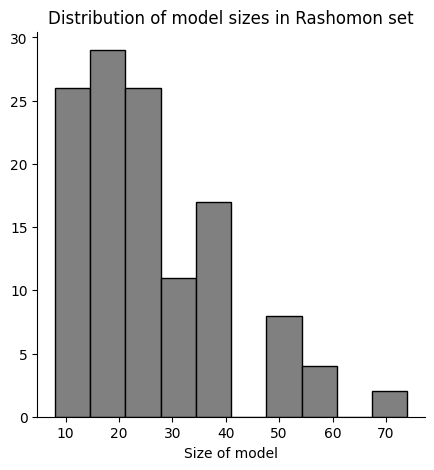

In [24]:
fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top']].set_visible(False)

ax.hist(model_sizes,
        color="grey", edgecolor="black")

ax.set_xlabel("Size of model")
ax.set_ylabel("")
ax.set_title("Distribution of model sizes in Rashomon set")

# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# plt.savefig("../Figures/price_charity/rset_size_dist.png", dpi=300, bbox_inches="tight")
plt.show()

In [95]:
losses_only = np.array([x[0] for x in all_losses])
losses_only = losses_only - np.min(losses_only)
losses_only = losses_only / np.max(losses_only) #* 70



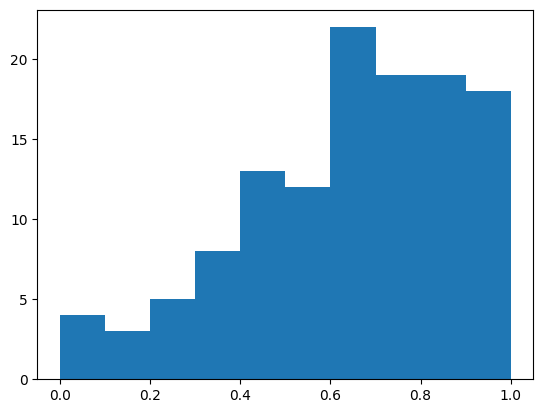

In [96]:
plt.hist(losses_only)

plt.show()

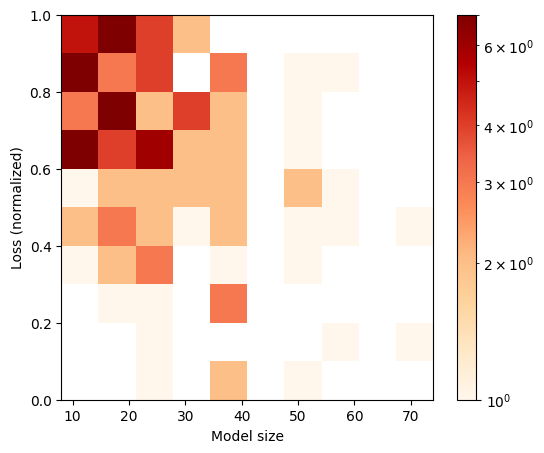

In [105]:
fig, ax = plt.subplots(figsize=(6,5))

h = ax.hist2d(model_sizes, losses_only, norm=colors.LogNorm(),
             cmap="OrRd")
fig.colorbar(h[3], norm=colors.NoNorm, ax=ax)

ax.set_xlabel("Model size")
ax.set_ylabel("Loss (normalized)")


# plt.savefig("../Figures/price_charity/rset_2d_hist.png", dpi=300, bbox_inches="tight")
plt.show()

Next, we look at the most common splits

In [50]:
splits_1 = np.zeros(rashomon_profiles[1].sigma[0].shape)
splits_2 = np.zeros(rashomon_profiles[15].sigma[0].shape)

for r_set in R_set:
    idx_1 = r_set[1]
    idx_2 = r_set[15]

    splits_1 += np.abs(rashomon_profiles[1].sigma[idx_1] - 1)
    splits_2 += np.abs(rashomon_profiles[15].sigma[idx_2] - 1)

splits_1 = splits_1 / len(R_set) * 100
splits_2 = splits_2 / len(R_set) * 100

In [51]:
splits_1

array([[58.53658537]])

In [52]:
splits_2

array([[64.22764228, 56.09756098,         inf],
       [98.37398374, 43.90243902, 56.09756098],
       [59.3495935 , 59.3495935 ,         inf],
       [82.92682927,         inf,         inf]])

### Lasso

In [34]:
from sklearn import linear_model

In [204]:
G = tva.alpha_matrix(all_policies)
D_matrix = tva.get_dummy_matrix(D, G, num_policies)

In [205]:
lasso = linear_model.Lasso(1e-4, fit_intercept=False)
lasso.fit(D_matrix, y)
alpha_est = lasso.coef_
y_tva = lasso.predict(D_matrix)

In [208]:
sqrd_err = mean_squared_error(y, y_tva)
print(sqrd_err)

lasso_loss = sqrd_err + 1e-4 * np.linalg.norm(alpha_est, ord=1)
print(lasso_loss)

0.007557087681478236
0.007559423517002552


In [240]:
best_pol_effect_tva = np.max(y_tva)
sqrd_err_best_pol_tva = (true_best_eff - best_pol_effect_tva)**2
print(f"{sqrd_err_best_pol_tva:.3e}")

best_pol_idx_tva = np.unique(D[np.where(y_tva == best_pol_effect_tva)])
for idx in best_pol_idx_tva:
    print(idx, all_policies[idx])

1.079e-04
176 (2, 4, 2, 2)


In [147]:
0.0075579 / sqrd_err

1.0001074909483656

In [145]:
sqrd_err * 1.0001

0.007557843390246384

In [144]:
print(alpha_est.size)
alpha_est[np.nonzero(alpha_est)]

240


array([ 7.97690697e-03, -3.49831158e-04,  8.19950066e-03,  1.06300281e-03,
        9.43166838e-04, -8.49020667e-04,  8.90114104e-05,  6.60306624e-04,
        9.26149847e-04,  4.65184327e-04, -6.44947383e-04, -1.19132656e-03])

### Causal trees

In [182]:
from rashomon import causal_trees

from CTL.causal_tree_learn import CausalTree

In [246]:
ctl_res = causal_trees.ctl(M, R, D, y, D_matrix)
y_ctl = ctl_res[3]

In [243]:
np.unique(y_ctl)

array([0.00813755, 0.0091202 , 0.00980804, 0.01479656])

In [242]:
sqrd_err_ctl = mean_squared_error(y, y_ctl)
print(f"{sqrd_err_ctl:.3e}")

7.558e-03


In [241]:
best_pol_effect_ctl = np.max(y_ctl)
sqrd_err_best_pol_ctl = (true_best_eff - best_pol_effect_ctl)**2
print(f"{sqrd_err_best_pol_ctl:.3e}")

best_pol_idx_ctl = np.unique(D[np.where(y_ctl == best_pol_effect_ctl)])
for idx in best_pol_idx_ctl:
    print(idx, all_policies[idx])

5.315e-05
137 (2, 1, 1, 2)
140 (2, 1, 2, 2)
143 (2, 1, 3, 2)
197 (3, 1, 1, 2)
200 (3, 1, 2, 2)
203 (3, 1, 3, 2)
